In [1]:
import os
import time
import h5py
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import misc
from sklearn import model_selection, preprocessing, metrics
from sklearn.utils import shuffle
from tqdm import tqdm
from keras.regularizers import l2
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import backend as K
import keras.backend.tensorflow_backend as KTF
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_PATH = '/kaggle/dev/carvana-image-masking-challenge-data'
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw_data')
TRAIN_PATH = os.path.join(RAW_DATA_PATH, 'train')
TEST_PATH = os.path.join(RAW_DATA_PATH, 'test')
TRAIN_MASKS_PATH = os.path.join(RAW_DATA_PATH, 'train_masks')
TRAIN_MASKS_CSV_PATH = os.path.join(RAW_DATA_PATH, 'train_masks.csv')
SAMPLE_SUBMISSION_PATH = os.path.join(RAW_DATA_PATH, 'sample_submission.csv')
METADATA_PATH = os.path.join(RAW_DATA_PATH, 'metadata.csv')
SUBMISSION_PATH = os.path.join(DATA_PATH, 'submissions')
ASSETS_PATH = os.path.join(DATA_PATH, 'assets')
MODELS_PATH = os.path.join(ASSETS_PATH, 'models')
TENSORBOARD_PATH = os.path.join(ASSETS_PATH, 'tensorboard')

In [3]:
train_masks_df = pd.read_csv(TRAIN_MASKS_CSV_PATH)
print('train_masks_df.shape', train_masks_df.shape)
train_masks_df.head()

train_masks_df.shape (5088, 2)


,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [4]:
def get_img_id(img_path):
    return img_path[:15]

img_ids = list(map(get_img_id, list(train_masks_df.img.values)))
img_ids[0:10]

['00087a6bd4dc_01',
 '00087a6bd4dc_02',
 '00087a6bd4dc_03',
 '00087a6bd4dc_04',
 '00087a6bd4dc_05',
 '00087a6bd4dc_06',
 '00087a6bd4dc_07',
 '00087a6bd4dc_08',
 '00087a6bd4dc_09',
 '00087a6bd4dc_10']

In [5]:
def load_image(img_id):
    img = misc.imread(os.path.join(TRAIN_PATH, img_id + ".jpg"))
    return img

# Return mask as 1/0 binary img
def load_mask(img_id):
    mask = misc.imread(os.path.join(TRAIN_MASKS_PATH, img_id + "_mask.gif"))
    mask = mask[:,:,0:3]
    mask[mask == 255] = 1
    return mask

# Helper functions to plot car, mask, masked_car
def plot_image(img_id):
    img = misc.imread(os.path.join(TRAIN_PATH, img_id + ".jpg"))
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()
    
def plot_mask(img_id):
    mask = misc.imread(os.path.join(TRAIN_MASKS_PATH, img_id + "_mask.gif"))
    imgplot = plt.imshow(mask)
    plt.axis('off')
    plt.show()
    
def plot_masked_image(img_id):
    img = misc.imread(os.path.join(TRAIN_PATH, img_id + ".jpg"))
    mask = misc.imread(os.path.join(TRAIN_MASKS_PATH, img_id + "_mask.gif"))
    mask = mask[:,:,0:3]
    mask[mask == 255] = 1 
    masked_img = img * mask
    imgplot = plt.imshow(masked_img)
    plt.axis('off')
    plt.show()

(1280, 1918, 3)


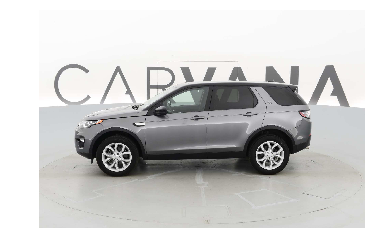

In [6]:
random_car_idx = int(np.random.random() * len(train_masks_df))
img = load_image(img_ids[random_car_idx])
print(img.shape)
plot_image(img_ids[random_car_idx])

In [8]:
# Constants
HEIGHT = 1280
WIDTH = 1918
CHANNELS = 3
BATCH_SIZE = 2
VALIDATION_STEPS = 64 # 64 * 16 = 1024 (~20% of train data)

In [9]:
def generate_training_batch(data, batch_size):
    X = np.zeros((batch_size, HEIGHT, WIDTH, CHANNELS))
    Y = np.zeros((batch_size, HEIGHT, WIDTH, CHANNELS))
    while True:
        batch_ids = np.random.choice(data,
                                     size=batch_size,
                                     replace=False)
        for idx, img_id in enumerate(batch_ids):
            X[idx] = load_image(img_id)
            Y[idx] = load_mask(img_id)

        yield X, Y

def generate_validation_batch(data, batch_size):
    X = np.zeros((batch_size, HEIGHT, WIDTH, CHANNELS))
    Y = np.zeros((batch_size, HEIGHT, WIDTH, CHANNELS))
    while True:
        batch_ids = np.random.choice(data,
                                     size=batch_size,
                                     replace=False)
        for idx, img_id in enumerate(batch_ids):
            X[idx] = load_image(img_id)
            Y[idx] = load_mask(img_id)

        yield X, Y

In [10]:
# Model
class BilinearUpSampling2D(Layer):
    def __init__(self, size=(1, 1), target_size=None, data_format='default', **kwargs):
        if data_format == 'default':
            data_format = K.image_data_format()
        self.size = tuple(size)
        if target_size is not None:
            self.target_size = tuple(target_size)
        else:
            self.target_size = None
        assert data_format in {'channels_last', 'channels_first'}, 'data_format must be in {tf, th}'
        self.data_format = data_format
        self.input_spec = [InputSpec(ndim=4)]
        super(BilinearUpSampling2D, self).__init__(**kwargs)

def FCN_Vgg16_32s(weight_decay=0.00005, batch_momentum=0.9, classes=2):
    img_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))
    #image_size = input_shape[0:2]
        
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', kernel_regularizer=l2(weight_decay))(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Convolutional layers transfered from fully-connected layers
    x = Conv2D(4096, (7, 7), activation='relu', padding='same', name='fc1', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    x = Conv2D(4096, (1, 1), activation='relu', padding='same', name='fc2', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    
    # classifying layer
    x = Conv2D(classes, (1, 1), kernel_initializer='he_normal', activation='linear', padding='valid', strides=(1, 1), kernel_regularizer=l2(weight_decay))(x)

    output = BilinearUpSampling2D(size=(32, 32))(x)

    model = Model(inputs=img_input, outputs=output)
    return model

In [11]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [12]:
ts = str(int(time.time()))
model_name = 'malhot'
num_epochs = 100
steps_per_epoch = 400
run_name = 'model={}-batch_size={}-num_epoch={}-steps_per_epoch={}-ts={}'.format(model_name,
                                                                          BATCH_SIZE,
                                                                          num_epochs,
                                                                          steps_per_epoch,
                                                                          ts)
tensorboard_loc = os.path.join(TENSORBOARD_PATH, run_name)
checkpoint_loc = 'model-{}-weights.h5'.format(ts)

earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=1, 
                              verbose=1, 
                              min_delta = 0.23,
                              mode='min',)

modelCheckpoint = ModelCheckpoint(checkpoint_loc,
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                 save_weights_only = True)

tensorboard = TensorBoard(log_dir=tensorboard_loc, histogram_freq=0,
                            write_graph=True, write_images=True)

callbacks_list = [modelCheckpoint, earlyStopping, tensorboard]

model = FCN_Vgg16_32s()
model.compile(loss=dice_coef_loss,
              optimizer='adam',
              metrics=['acc'])

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1280, 1918, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 1280, 1918, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 1280, 1918, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 640, 959, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 640, 959, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 640, 959, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 320, 479, 128)     0         
__________

In [13]:
train_ids, validation_ids = model_selection.train_test_split(img_ids, random_state=42, test_size=0.20)
train_generator = generate_training_batch(train_ids, BATCH_SIZE)
valid_generator = generate_validation_batch(validation_ids, BATCH_SIZE)

print('Starting run {}'.format(run_name))
history = model.fit_generator(
        train_generator, 
        steps_per_epoch = 318, 
        epochs = 25,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = VALIDATION_STEPS)

model_path = os.path.join(MODELS_PATH, 'model-{}.h5'.format(ts))
history_path = os.path.join(MODELS_PATH, 'model-{}.history'.format(ts))
model.save(model_path)
pickle.dump(history.history, open(history_path, "wb"))
print('Saved model at {}'.format(model_path))
print('Saved model history at {}'.format(history_path))

Starting run model=malhot-batch_size=2-num_epoch=100-steps_per_epoch=400-ts=1503556984
Epoch 1/25


InvalidArgumentError: Incompatible shapes: [2,1280,1918] vs. [2,40,59]
	 [[Node: Equal = Equal[T=DT_INT64, _device="/job:localhost/replica:0/task:0/gpu:0"](ArgMax, ArgMax_1)]]
	 [[Node: add_18/_35 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_2540_add_18", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Equal', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2683, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2793, in run_ast_nodes
    if self.run_code(code, result):
  File "/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-d06c11850f13>", line 34, in <module>
    metrics=['acc'])
  File "/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/keras/engine/training.py", line 964, in compile
    append_metric(i, 'acc', masked_fn(y_true, y_pred, mask=masks[i]))
  File "/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/keras/engine/training.py", line 485, in masked
    score_array = fn(y_true, y_pred)
  File "/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/keras/metrics.py", line 26, in categorical_accuracy
    K.argmax(y_pred, axis=-1)),
  File "/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 1474, in equal
    return tf.equal(x, y)
  File "/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 672, in equal
    result = _op_def_lib.apply_op("Equal", x=x, y=y, name=name)
  File "/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Incompatible shapes: [2,1280,1918] vs. [2,40,59]
	 [[Node: Equal = Equal[T=DT_INT64, _device="/job:localhost/replica:0/task:0/gpu:0"](ArgMax, ArgMax_1)]]
	 [[Node: add_18/_35 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_2540_add_18", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
